In [2]:
from fastai import *
from fastai.basics import *
from fastai.vision.all import *

import numpy as np
import pandas as pd

torch_device = torch.device('cuda')

In [3]:
path = Path('/kaggle/input/digit-recognizer')

## Loading Training Data

In [4]:
train_df = pd.read_csv(path/'train.csv');train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Setup Dataset and Dataloader

Image data is contained within CSV/dataframe.

get_x pulls out pixel data from dataframe row puts it into a tensor and wraps it with an ImageTensor object

get_y pulls out label from dataframe row puts it into a string since that's what fastai will expect given we're not defining the vocab up front.


In [5]:
# def get_x(r):
#     c = tensor([r[f'pixel{v}'] for v in range(784)]).float().view(28,28).unsqueeze(0)
#     return TensorImage(torch.cat([c,c,c]))

def get_x(r):
    c = tensor([r[f'pixel{v}'] for v in range(784)]).float().view(28,28).unsqueeze(0)
    return TensorImage(torch.cat([c,c,c]))

def get_y(r):
    return str(r['label']) # Return class as a string; Given no vocab defined

In [6]:
# see if they work
r = train_df.iloc[0]
get_x(r).dtype,get_y(r)

(torch.float32, '1')

<AxesSubplot:>

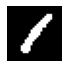

In [7]:
# see if we can display an image from the training data
show_image(get_x(r))

In [8]:
# fast ai datablock to apply batch transforms (augmentation and normalization) and will do a random 20% validation split
batch_tfms = [*aug_transforms(do_flip=False,), Normalize.from_stats(*imagenet_stats)]
db = DataBlock(blocks=[ImageBlock,CategoryBlock],get_x=get_x,get_y=get_y,
              batch_tfms = batch_tfms)

dls = db.dataloaders(train_df,bs=128)

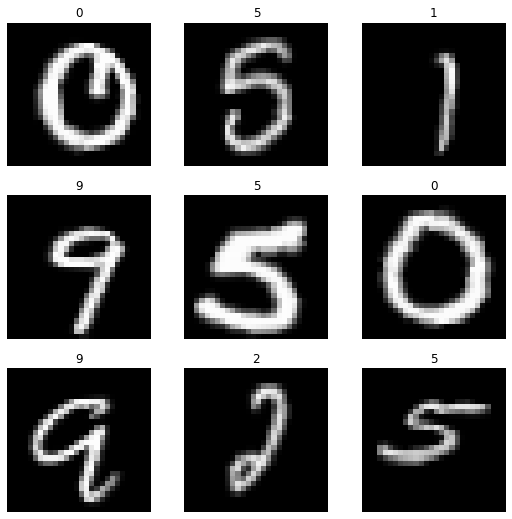

In [9]:
# preview a batch
dls.show_batch()

## Let's Train

In [10]:
learn = vision_learner(dls,resnet34,metrics=accuracy,loss_func=CrossEntropyLossFlat())

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
learn.fit(1) # Let's train one opoch

epoch,train_loss,valid_loss,accuracy,time
0,0.445977,0.240876,0.926310,04:14


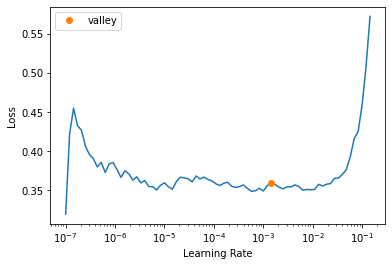

In [12]:
# calculate a sane learning rate
lrs = learn.lr_find()

In [13]:
lrs

SuggestedLRs(valley=0.0014454397605732083)

In [14]:
# Some callbacks to manage training
cbs = [
    GradientAccumulation(),
    MixedPrecision(),
    SaveModelCallback(monitor='accuracy', comp=np.greater, min_delta=0.001),
    ReduceLROnPlateau(monitor='accuracy', comp=np.greater, min_delta=0.001, patience=2),
#MixUp(0.4),
#EarlyStoppingCallback(monitor='accuracy', comp=np.greater, min_delta=0.001, patience=3),
      ]

In [17]:
learn.fine_tune(15, lrs.valley,cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.308628,0.222360,0.930476,04:18


Better model found at epoch 0 with accuracy value: 0.930476188659668.


epoch,train_loss,valid_loss,accuracy,time
0,0.252415,0.159197,0.950833,04:34
1,0.191727,0.127201,0.962381,04:35
2,0.139043,0.097652,0.971548,04:35
3,0.111370,0.087915,0.974643,04:38
4,0.091363,0.065039,0.979643,04:35
5,0.082388,0.065114,0.979881,04:36
6,0.063773,0.062645,0.979881,04:36
7,0.061134,0.055169,0.983929,04:37
8,0.054171,0.044139,0.987619,04:36
9,0.045933,0.045867,0.986548,04:37


Better model found at epoch 0 with accuracy value: 0.9508333206176758.
Better model found at epoch 1 with accuracy value: 0.9623809456825256.
Better model found at epoch 2 with accuracy value: 0.9715476036071777.
Better model found at epoch 3 with accuracy value: 0.9746428728103638.
Better model found at epoch 4 with accuracy value: 0.9796428680419922.
Epoch 6: reducing lr to 2.0746590449364716e-05
Better model found at epoch 7 with accuracy value: 0.9839285612106323.
Better model found at epoch 8 with accuracy value: 0.9876190423965454.
Epoch 10: reducing lr to 7.607058464548466e-06
Epoch 12: reducing lr to 2.0871065756146915e-06
Epoch 14: reducing lr to 2.4711843151750854e-10


## Review Submission Sample

In [15]:
sample_submission = pd.read_csv(path/'sample_submission.csv',);sample_submission

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


## Generate Submission File

In [16]:
test_df = pd.read_csv(path/'test.csv');test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# pixel data from dataframe into a tensor
td = tensor(test_df.values).reshape(-1,28,28).unsqueeze(1);td.shape

torch.Size([28000, 1, 28, 28])

<AxesSubplot:>

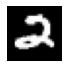

In [75]:
# tensor into a list of of TensorImage
td = [TensorImage(torch.cat([td[i],td[i],td[i]])) for i in range(td.shape[0])]
show_image(td[0])

In [76]:
# evaluate model on whole test dataset
test_dl = learn.dls.test_dl(td)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [77]:
# create df and generate csv from decoded predictions
submission = pd.DataFrame(np.arange(len(td))+1, columns=['ImageId'])
submission['Label'] = decoded
submission.head()

submission.to_csv("submission.csv",index=False)